<a href="https://colab.research.google.com/github/Shane85437/The-Fountain/blob/main/RoPC_7D_Galactic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas emcee corner matplotlib scipy --quiet
import numpy as np
import pandas as pd
import emcee
import corner
import matplotlib.pyplot as plt
import time
from google.colab import files
import io

In [ ]:
raw_data_csv = """galaxy_name,R_kpc,V_obs,err_V,V_star,V_gas
M33,0.5,30,5,25,5
M33,1.0,45,6,35,8
M33,2.0,80,8,55,15
M33,3.0,95,9,65,18
M33,5.0,110,10,70,20
M33,7.0,115,11,75,22
M33,10.0,120,12,40,25
M33,12.0,119,13,35,28
M33,15.0,118,15,30,30
M83,0.2,50,6,45,5
M83,0.5,90,8,80,10
M83,1.0,120,10,100,12
M83,2.0,135,11,110,15
M83,5.0,145,12,90,18
M83,8.0,148,13,80,20
M83,10.0,150,15,60,22
M83,15.0,149,16,50,25
M83,18.0,148,18,40,28
M83,20.0,147,20,35,30
Malin1,1.0,60,10,50,10
Malin1,5.0,100,12,70,15
Malin1,10.0,150,15,80,20
Malin1,20.0,200,18,60,25
Malin1,30.0,220,20,50,28
Malin1,50.0,240,20,40,30
Malin1,70.0,240,22,30,32
Malin1,100.0,240,25,20,30
NGC6946,0.3,40,8,35,5
NGC6946,0.8,80,10,70,10
NGC6946,1.5,120,12,110,12
NGC6946,3.0,160,15,140,15
NGC6946,5.0,190,18,160,20
NGC6946,7.0,200,20,170,22
NGC6946,10.0,205,22,140,25
NGC6946,12.0,204,23,130,26
NGC6946,15.0,203,24,110,28
NGC6946,18.0,202,25,100,30
NGC6946,20.0,201,26,90,32
NGC3198,0.5,30,5,25,5
NGC3198,1.0,60,7,50,10
NGC3198,2.0,100,9,90,12
NGC3198,4.0,130,11,120,15
NGC3198,6.0,140,13,130,18
NGC3198,8.0,145,15,135,20
NGC3198,10.0,150,16,120,22
NGC3198,12.0,149,17,110,24
NGC3198,15.0,148,18,90,26
NGC3198,18.0,147,19,80,28
NGC3198,20.0,146,20,70,30
NGC3198,22.0,145,21,60,32
NGC3198,25.0,144,22,50,35
"""

df_all = pd.read_csv(io.StringIO(raw_data_csv))
df_all["V_bary"] = np.sqrt(df_all["V_star"]**2 + df_all["V_gas"]**2)

galaxies = {g: d[["R_kpc","V_obs","err_V","V_bary"]].reset_index(drop=True)
            for g, d in df_all.groupby("galaxy_name")}

print(f"Loaded {len(galaxies)} galaxies, {len(df_all)} data points total.")

Loaded 5 galaxies, 51 data points total.


In [ ]:
def f_kernel(R, ell):
    x = R / ell
    x_safe = np.where(np.abs(x) < 1e-8, 1e-8, x)
    f = 1.0 - (1.0 / x_safe) * np.arctan(x_safe)
    small = np.abs(x) < 1e-3
    if np.any(small):
        xx = x[small]
        f[small] = (xx**2) / 3.0 - (xx**4) / 15.0
    return f

def log_prior(theta):
    amp, ell, *Us = theta
    if not (0.0 < amp < 1e6 and 1e-4 < ell < 50.0 and all(0.1 < U < 5.0 for U in Us)):
        return -np.inf
    return 0.0

def log_like(theta):
    amp, ell, *Us = theta
    total_chi2 = 0.0
    for i, (g_name, df) in enumerate(galaxies.items()):
        R, Vobs, err, Vb = [df[c].values for c in ["R_kpc","V_obs","err_V","V_bary"]]
        Vphi2 = amp * f_kernel(R, ell)
        Vmod = np.sqrt((Us[i]*Vb)**2 + Vphi2)
        total_chi2 += np.sum(((Vobs - Vmod)/err)**2)
    return -0.5 * total_chi2

def log_prob(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp): return -np.inf
    return lp + log_like(theta)

In [ ]:
ndim = 7  # amp, ell, and 5 U_i
nwalkers = 64
nsteps = 20000
nburn = 5000
thin = 10

p0 = np.array([1200, 6.0, 3.5, 3.5, 4.7, 3.5, 3.0])
rng = np.random.default_rng(2025)
pos = p0 * (1 + 1e-3 * rng.standard_normal((nwalkers, ndim)))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
print("Running MCMC...")
t0 = time.time()
sampler.run_mcmc(pos, nsteps, progress=True)
print(f"Done in {time.time()-t0:.1f}s")

flat = sampler.get_chain(discard=nburn, thin=thin, flat=True)
np.save("samples_5gal.npy", flat)
print(f"Saved {len(flat)} posterior samples.")

Running MCMC...


100%|██████████| 20000/20000 [06:50<00:00, 48.77it/s]


Done in 410.3s
Saved 96000 posterior samples.


       param        median           16%           84%
0          A  73038.503205  62295.648127  85618.942615
1        ell     14.542016     12.375306     16.937055
2      U_M33      1.268868      1.199322      1.338597
3      U_M83      1.223149      1.174103      1.271966
4   U_Malin1      1.295103      1.168869      1.416910
5  U_NGC6946      0.993962      0.946110      1.041083
6  U_NGC3198      1.142418      1.094953      1.189854


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

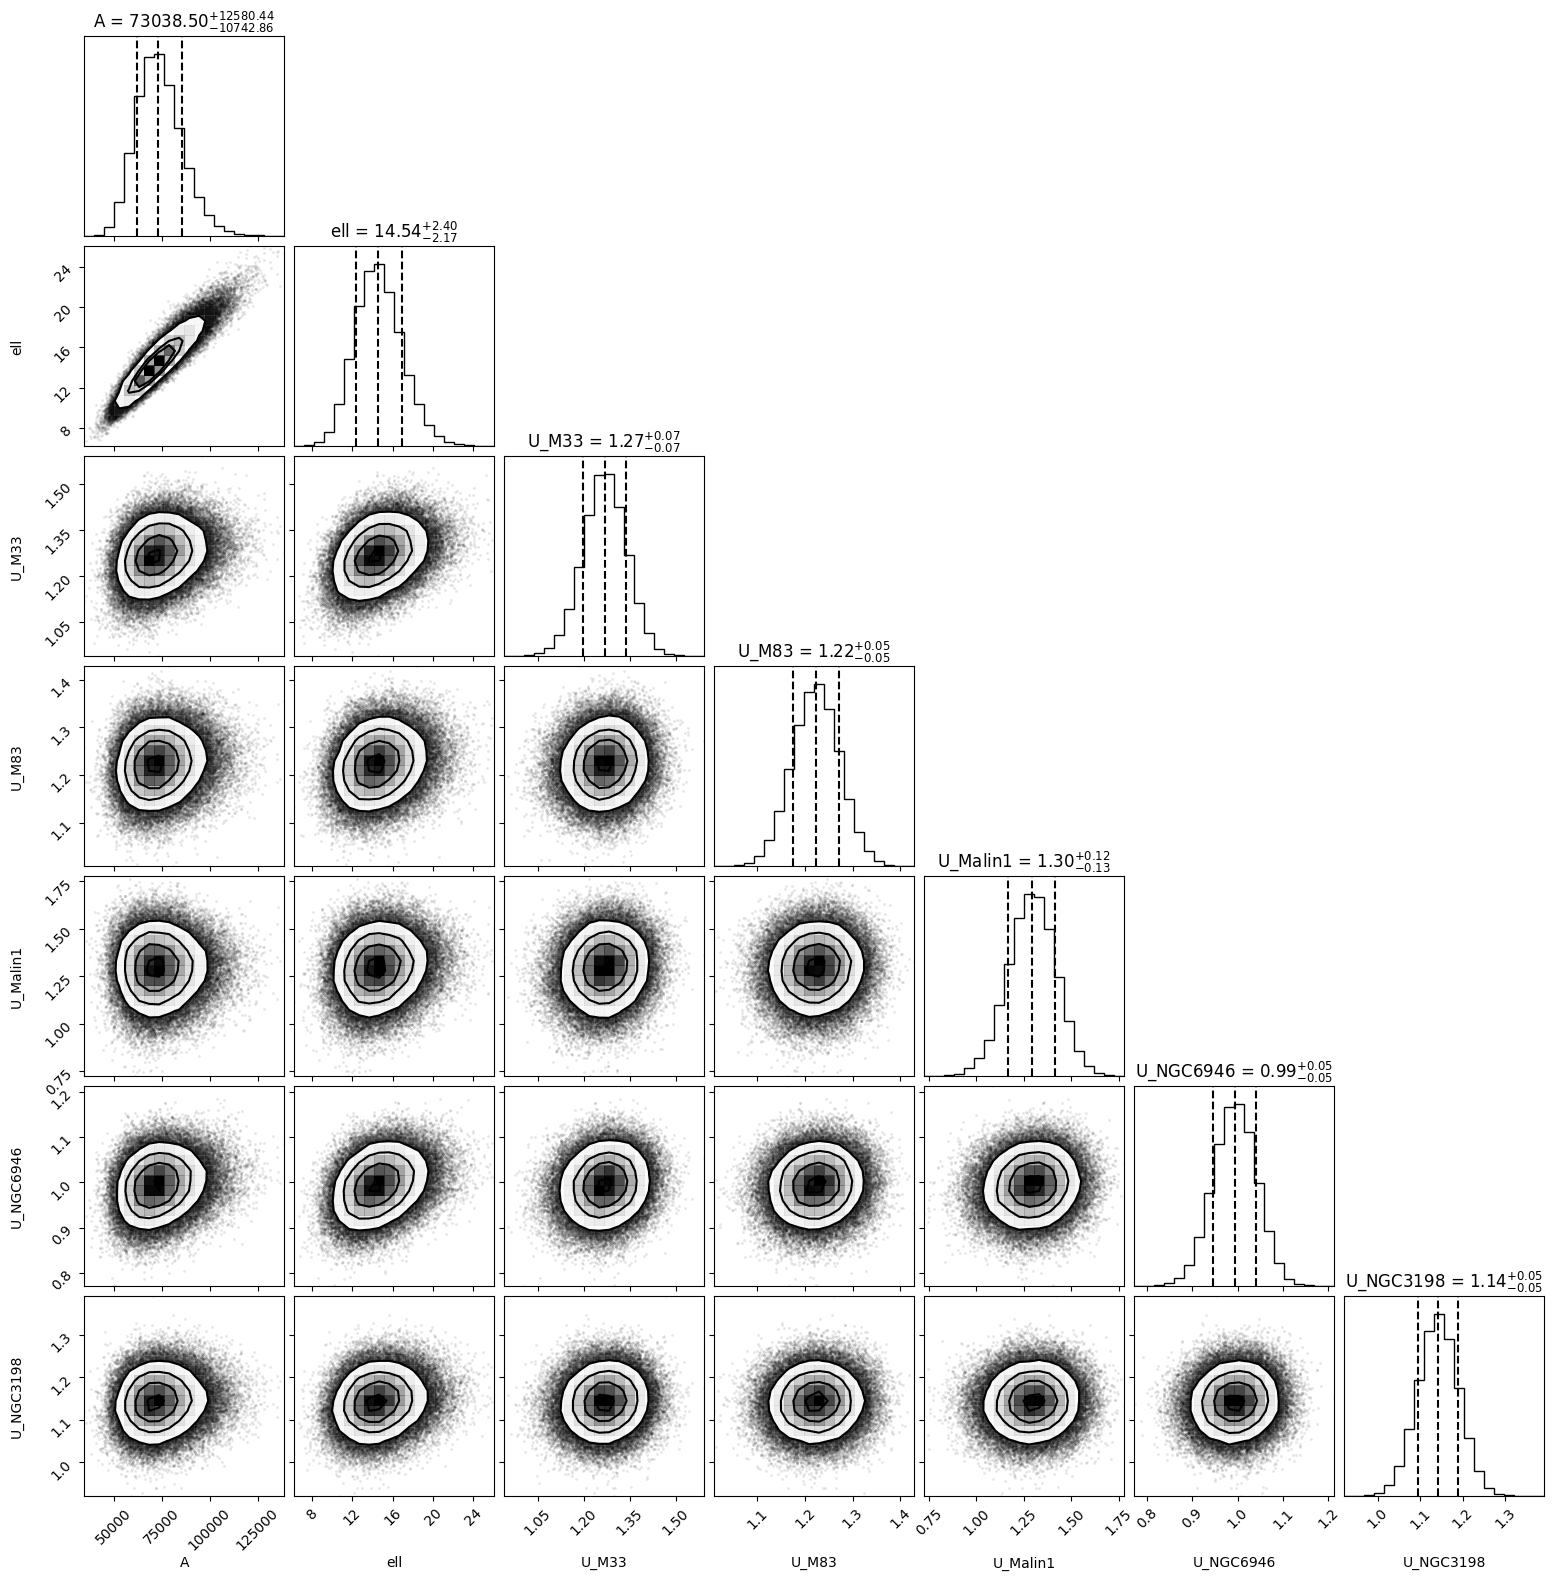

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def cred(x): return np.percentile(x, [16,50,84])
param_names = ["A","ell","U_M33","U_M83","U_Malin1","U_NGC6946","U_NGC3198"]

summary = pd.DataFrame({
    "param": param_names,
    "median": [cred(flat[:,i])[1] for i in range(ndim)],
    "16%": [cred(flat[:,i])[0] for i in range(ndim)],
    "84%": [cred(flat[:,i])[2] for i in range(ndim)]
})
print(summary)
summary.to_csv("summary_5gal.csv", index=False)
files.download("summary_5gal.csv")

fig = corner.corner(flat, labels=param_names, show_titles=True, quantiles=[0.16,0.5,0.84])
fig.savefig("corner_5gal.png", dpi=300, bbox_inches="tight")
plt.show()
files.download("corner_5gal.png")

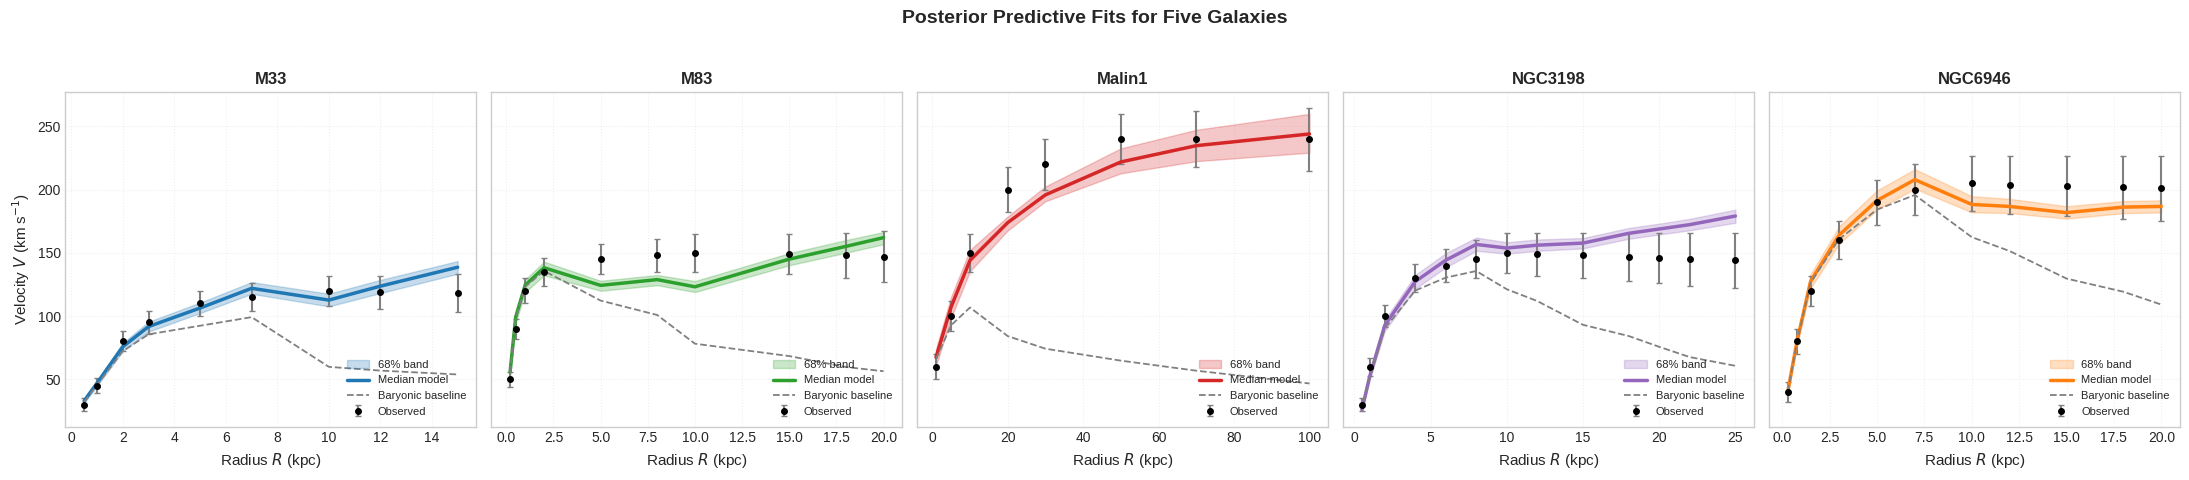

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Convert to DataFrame for easier column access
flat_df = pd.DataFrame(flat, columns=param_names)

# === Figure Setup ===
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 5, figsize=(22, 5), sharey=True)

# --- Color and style palette ---
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#ff7f0e']  # Consistent palette per galaxy

for i, (g_name, df) in enumerate(galaxies.items()):
    R = df['R_kpc'].values
    V_obs = df['V_obs'].values
    err_V = df['err_V'].values
    V_bary = df['V_bary'].values

    # --- Compute model predictions from random posterior draws ---
    idx_samples = np.random.choice(len(flat_df), 200, replace=False)
    V_models = []
    for idx in idx_samples:
        amp, ell, *Us = flat_df.iloc[idx]
        U = Us[i]
        Vphi2 = amp * f_kernel(R, ell)
        V_mod = np.sqrt((U * V_bary)**2 + Vphi2)
        V_models.append(V_mod)
    V_models = np.array(V_models)
    p16, p50, p84 = np.percentile(V_models, [16, 50, 84], axis=0)

    # --- Plot ---
    ax = axes[i]
    ax.errorbar(R, V_obs, yerr=err_V, fmt='o', markersize=4,
                color='black', ecolor='gray', capsize=2, label='Observed')
    ax.fill_between(R, p16, p84, alpha=0.25, color=colors[i], label='68% band')
    ax.plot(R, p50, color=colors[i], linewidth=2.5, label='Median model')
    ax.plot(R, np.median(flat_df.iloc[:, 2 + i]) * V_bary,
            color='gray', linestyle='--', linewidth=1.3, label='Baryonic baseline')

    # --- Axes formatting ---
    ax.set_xlabel('Radius $R$ (kpc)', fontsize=11)
    ax.set_title(g_name, fontsize=12, fontweight='semibold')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(alpha=0.3, linestyle=':')
    ax.legend(fontsize=8, loc='lower right', frameon=False)
    if i == 0:
        ax.set_ylabel('Velocity $V$ (km s$^{-1}$)', fontsize=11)

# --- Global title and layout ---
plt.suptitle('Posterior Predictive Fits for Five Galaxies', fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.85) # Adjust layout to prevent title overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap

plt.savefig("combined_predictive_5gal.png", dpi=300, bbox_inches="tight")
plt.show()
files.download("combined_predictive_5gal.png")